In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import warnings
warnings.filterwarnings("ignore") 
import os

In [2]:
directory = r"C:\Users\kumar\Desktop\datasets\surat_flats_dataset"
for filename in os.listdir(directory):
    file_path = os.path.join(directory, filename)
    if os.path.isfile(file_path):
        print(file_path)


C:\Users\kumar\Desktop\datasets\surat_flats_dataset\surat_uncleaned.csv


In [3]:
df = pd.read_csv(r"C:\Users\kumar\Desktop\datasets\surat_flats_dataset\surat_uncleaned.csv")

In [4]:
df.head()

,property_name,areaWithType,square_feet,transaction,status,floor,furnishing,facing,description,price_per_sqft,price
0,2 BHK Apartment for Sale in Dindoli Surat,Carpet Area,644 sqft,New Property,Poss. by Oct '24,5 out of 10,Unfurnished,West,"Luxury project with basement parking, Solar ro...","₹2,891 per sqft",₹33.8 Lac
1,2 BHK Apartment for Sale in Althan Surat,Super Area,1278 sqft,New Property,Poss. by Jan '26,6 out of 14,Unfurnished,South -West,2 And 3 BHK Luxurious Flat for Sell In New Alt...,"₹3,551 per sqft",₹45.4 Lac
2,2 BHK Apartment for Sale in Pal Gam Surat,Super Area,1173 sqft,Resale,Ready to Move,5 out of 13,Semi-Furnished,East,This affordable 2 BHK flat is situated along a...,"₹3,800 per sqft",₹44.6 Lac
3,2 BHK Apartment for Sale in Jahangirabad Surat,Carpet Area,700 sqft,New Property,Ready to Move,6 out of 14,Unfurnished,East,2 BHK Flat For sell IN Jahangirabad Prime Loca...,"₹3,966 per sqft",₹47 Lac
4,"2 BHK Apartment for Sale in Orchid Fantasia, P...",Super Area,1250 sqft,Orchid Fantasia,New Property,Unfurnished,2,2,"Multistorey Apartment for Sale in Palanpur, Su...","₹3,600 per sqft",₹45 Lac


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4525 entries, 0 to 4524
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   property_name   4525 non-null   object
 1   areaWithType    4525 non-null   object
 2   square_feet     4525 non-null   object
 3   transaction     4421 non-null   object
 4   status          4524 non-null   object
 5   floor           4480 non-null   object
 6   furnishing      4185 non-null   object
 7   facing          3936 non-null   object
 8   description     3154 non-null   object
 9   price_per_sqft  4157 non-null   object
 10  price           4525 non-null   object
dtypes: object(11)
memory usage: 389.0+ KB


## Data Cleaning

### We see columns like square_feet, price, price_per_sqft contains string values. We will extract region from property_name and floor information from floor column.  WIll also drop null values wherever applicable.

In [6]:
import re

## Getting area name from property name
def extract_area_location(text):
    # regex pattern to capture the last "in" before "Surat"
    pattern = r'in\s+(.*?)\s+Surat'
    matches = re.findall(pattern, text, re.IGNORECASE)
    if matches:
        return matches[-1].strip()
    else:
        return 'Surat'

    
## Getting numeric value from values containing text as well
def convert_to_numeric_from_str(text):
    # regex pattern to capture numeric values, including commas, periods
    pattern = r'[,\.\d]+'
    match = re.search(pattern, text)
    
    if match:
        numeric_value = int(match.group(0).replace(',', '').replace('.', ''))
        return numeric_value
    else:
        return np.nan

    
# Function to split floor information
def split_floor_info(floor):
    # Check if floor is not NaN
    if isinstance(floor, str):
        # Check "out of" in exp-"4 out of 10"
        if "out of" in floor:
            match = re.match(r'(\D+|\d+)\s+out\s+of\s+(\d+)', floor)
            if match:
                if "Ground" in match.group(1) or "Lower" in match.group(1):
                    return pd.Series([0, int(match.group(2))])

                if "Upper" in match.group(1):
                    return pd.Series([int(match.group(2)), int(match.group(2))])
                return pd.Series([match.group(1), int(match.group(2))])
        else:
            try:
                # Try to convert to integer
                current_floor = int(floor)
                return pd.Series([current_floor, np.nan])
            except ValueError:
                # it's a non-numeric value
                if "Ground" in floor or "Lower" in floor:
                    return pd.Series([0, np.nan])
                return pd.Series([floor, np.nan])

    # Return NaN for both current floor and total floors if floor is NaN
    return pd.Series([np.nan, np.nan])


## Function to convert to numeric
def convert_to_numeric(value):
    try:
        return pd.to_numeric(value)
    except ValueError:
        return value

In [7]:
## Converting price, square_feet to numeric after removing string literals

df['area'] = df['property_name'].apply(lambda x: extract_area_location(x))
df['price_per_sqft'] = df['price_per_sqft'].apply(lambda x: convert_to_numeric_from_str(str(x)))
df['price'] = df['price'].apply(lambda x: convert_to_numeric_from_str(str(x)))
df['square_feet'] = df['square_feet'].apply(lambda x: convert_to_numeric_from_str(str(x)))
df['price'] = df['price']*100000

In [8]:
### Getting number of beds and floor Information
df['num_of_bedrooms'] = df['property_name'].apply(lambda x: x[0])
df[['current_floor', 'total_floors']] = df['floor'].apply(split_floor_info)
df['current_floor'] = df['current_floor'].apply(lambda x: convert_to_numeric(x))

In [9]:
df['transaction'].unique()

array(['New Property', 'Resale', 'Orchid Fantasia', 'Unfurnished',
       'Orchid Gardenia', 'Congo', 'Furnished', nan, 'Semi-Furnished',
       'Main Road, Garden/Park', '1', '3', '4', 'Yes', 'No',
       'Mahavir Nagar', '3 Covered', 'Shagun Residency', '2', 'Main Road',
       '10 m', 'Other', '1 Covered', 'Soham Elegance', 'Garden/Park',
       'Aakash Echo Point', 'Sundaram Residency', '5', 'Jolly Residency',
       'Mangalam Heights', 'Green City', 'Pool, Garden/Park, Main Road',
       '6', 'Co-operative Society', 'Vatsalya Bungalows', '20 Covered,',
       'Raghuvir Silverstone', '8 m', 'Casa Rivera'], dtype=object)

In [10]:
df['furnishing'].unique()

array(['Unfurnished', 'Semi-Furnished', '2', 'Anand Aspire', 'East', '1',
       'Furnished', nan, '3', '1 Covered,', '2 Covered', '1 Covered',
       'Freehold', 'West', '26 Covered', 'Main Road', 'No', 'North',
       '1 Open', '6', 'Co-operative Society', '> 10', '4',
       'Nilkanth Seven Homes', 'Aagam Navkar', '10 Open',
       'Vinayak Enclave', '5 Covered,', 'South -West',
       'Pool, Garden/Park, Main Road', 'Garden/Park, Main Road', '7 m',
       '30 m', '50 Covered,', 'South', '12 m', 'Yes', 'Gruham Luxuria',
       '2 Covered,', 'Congo', 'Prayosha Shine', 'North - East',
       'Vaishnodevi Ideal Homes', 'Santvan Lexon', 'Sangini Epitome',
       '100 Covered', 'Nirvana Gladiolus', '7', '5 Covered', '5',
       'Raghuvir Spalex', '50 Open', 'South - East', 'North - West',
       '20 m', '20 Open', 'Garden/Park', '10 m', 'Sattvam',
       'Pramukh Amaya', 'Sun Sarvam', '3 Covered', '2 Open', '6 m',
       'Avadh Kimberly', 'Happy Glorious', 'DMD Aura', 'Freedom Tower',
  

#### Looking at the transaction and furnishing details, its giving mixed values, hence are of no importance to our analysis

In [11]:
df['current_floor'].unique()

array([5, 6, 'Unfurnished', 'New Property', 7, 3, 1, 4, 2, 'Resale', 0, 9,
       'Freehold', 12, 10, 13, nan, 8, 'Furnished', 'Congo', 14, 16, 11,
       'No', 'Yes', 'Semi-Furnished', 'Other', 'The Polaris Avenue', 15,
       'Co-operative Society', 18, 20, 'Om Residency',
       'Milestone Regalia', 17, 19], dtype=object)

In [12]:
## Keeping Original data backup
df_org = df.copy()

In [13]:
### Removing rows with no floor information
df['current_floor'] = pd.to_numeric(df['current_floor'], errors='coerce')
df.dropna(subset=['current_floor'], inplace=True)

In [14]:
df['areaWithType'].unique()

array(['Carpet Area', 'Super Area', 'Plot Area', 'Transaction'],
      dtype=object)

In [15]:
df['num_of_bedrooms'].unique()

array(['2', ' ', '1', '3', '4', '7', '5', '8', '6', '9'], dtype=object)

In [16]:
## Removing rows with areaType as Transaction and no_bedroom Info
df = df[df['areaWithType'] != "Transaction"]
df = df[df['num_of_bedrooms'] != ' ']

In [17]:
## Checking for any missing values
df.isna().sum()

property_name        0
areaWithType         0
square_feet          0
transaction          0
status               0
floor                0
furnishing           0
facing              19
description        957
price_per_sqft     274
price              151
area                 0
num_of_bedrooms      0
current_floor        0
total_floors         0
dtype: int64

In [18]:
df.dropna(subset=['price_per_sqft', 'price'], inplace=True)
df.isna().sum()

property_name        0
areaWithType         0
square_feet          0
transaction          0
status               0
floor                0
furnishing           0
facing               2
description        827
price_per_sqft       0
price                0
area                 0
num_of_bedrooms      0
current_floor        0
total_floors         0
dtype: int64

In [19]:
## Final data for EDA
df.shape

(3016, 15)

### Exploratory Data Analysis wrt to BHK, Location , floor, areaType, furnishing

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3016 entries, 0 to 4517
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   property_name    3016 non-null   object 
 1   areaWithType     3016 non-null   object 
 2   square_feet      3016 non-null   float64
 3   transaction      3016 non-null   object 
 4   status           3016 non-null   object 
 5   floor            3016 non-null   object 
 6   furnishing       3016 non-null   object 
 7   facing           3014 non-null   object 
 8   description      2189 non-null   object 
 9   price_per_sqft   3016 non-null   float64
 10  price            3016 non-null   float64
 11  area             3016 non-null   object 
 12  num_of_bedrooms  3016 non-null   object 
 13  current_floor    3016 non-null   float64
 14  total_floors     3016 non-null   float64
dtypes: float64(5), object(10)
memory usage: 377.0+ KB


### Getting measure of the central tendency and variability in data. Having that Info, later check those variablility wrt to area, Floor Type and Location

In [21]:
df[['square_feet', 'price_per_sqft', 'price']].describe()

,square_feet,price_per_sqft,price
count,3016.000000,3016.000000,3.016000e+03
mean,1910.573939,5282.637268,2.277371e+07
std,7215.013676,7042.423000,1.029998e+08
min,3.000000,4.000000,1.000000e+05
25%,976.750000,3610.000000,5.100000e+06
50%,1372.500000,4500.000000,1.110000e+07
75%,2200.000000,5635.500000,2.550000e+07
max,390045.000000,194444.000000,5.344400e+09


### There is outliers in the data, Like price_per_sqft can't be just rs 4. Lets remove them first.

In [22]:
Q1 = df['price_per_sqft'].quantile(0.25)
Q3 = df['price_per_sqft'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df = df[(df['price_per_sqft'] >= lower_bound) & (df['price_per_sqft'] <= upper_bound)]

In [23]:
### Lets get the statistics again !
df[['square_feet', 'price_per_sqft', 'price']].describe()

,square_feet,price_per_sqft,price
count,2866.000000,2866.000000,2.866000e+03
mean,1770.504187,4551.606071,2.055014e+07
std,1210.330707,1388.302837,2.287478e+07
min,3.000000,731.000000,1.000000e+05
25%,1000.000000,3571.000000,5.100000e+06
50%,1393.000000,4400.500000,1.100000e+07
75%,2198.750000,5454.750000,2.547500e+07
max,9962.000000,8671.000000,9.990000e+07


<Axes: xlabel='square_feet', ylabel='price_per_sqft'>

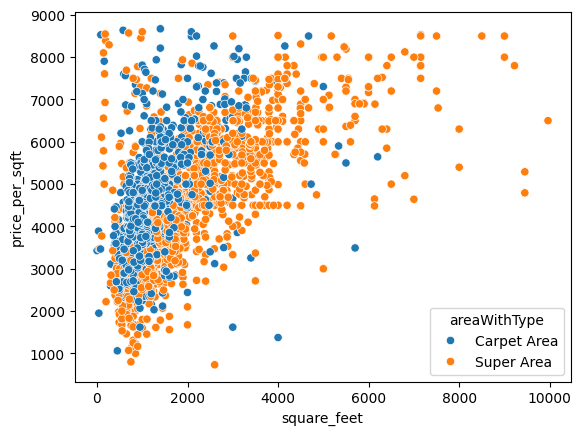

In [24]:
### Understanding relationship between flat area as square_feet vs price_per_sqft wrt areaType
sns.scatterplot(data=df, x="square_feet", y="price_per_sqft", hue="areaWithType")

#### Looking at Scatter Plot, Its unclear which area is costly. The average price per square foot looks identical in both areas. Lets varify that with statistics.

In [25]:
df.groupby(['areaWithType'])['price_per_sqft'].mean()

areaWithType
Carpet Area    4486.496281
Super Area     4583.433766
Name: price_per_sqft, dtype: float64

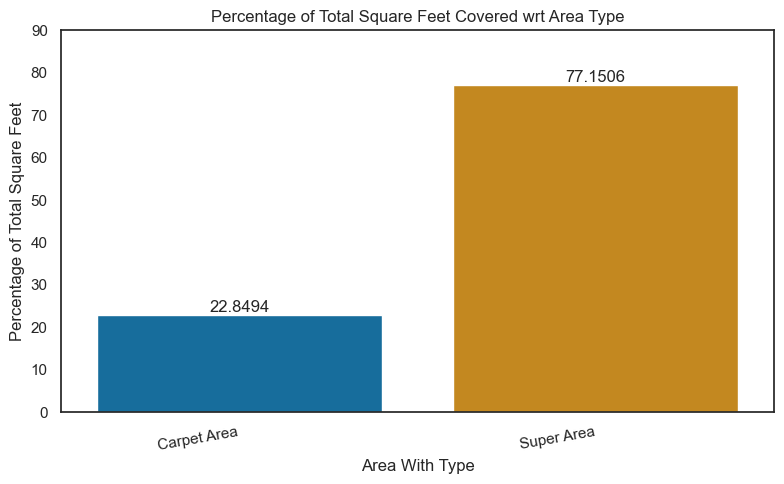

In [26]:
### Distribution of areas in Carpert and Super Area
area_coverage = df.groupby('areaWithType')['square_feet'].sum().reset_index()
total_square_feet = area_coverage['square_feet'].sum()
area_coverage['percentage'] = (area_coverage['square_feet'] / total_square_feet) * 100

sns.set(style="white")
plt.figure(figsize=(8, 5))
ax = sns.barplot(data=area_coverage, x='areaWithType', y='percentage', palette='colorblind')
for bars in ax.containers:
    ax.bar_label(bars)
ax.set_ylim(0, 90)
plt.xlabel('Area With Type')
plt.ylabel('Percentage of Total Square Feet')
plt.title('Percentage of Total Square Feet Covered wrt Area Type')
plt.xticks(rotation=10, ha='right')
plt.tight_layout() 
plt.show()


### It is observed that 77% of the total land area for sale belongs to Super Area.

<Axes: xlabel='square_feet', ylabel='price_per_sqft'>

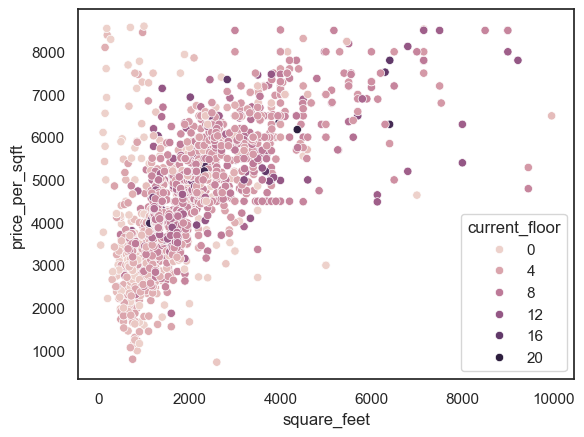

In [27]:
### Understanding relationship between flat area as square_feet vs price_per_sqft wrt Floor
### Analysis just for Super Area
df_sup = df[df['areaWithType'] == "Super Area"]
sns.scatterplot(data=df_sup, x="square_feet", y="price_per_sqft", hue="current_floor")

In [28]:
df_sup.groupby(['current_floor'])['price_per_sqft'].mean()

current_floor
0.0     4181.557377
1.0     4172.408000
2.0     3936.612903
3.0     3762.089552
4.0     4018.896104
5.0     4999.534574
6.0     4780.193548
7.0     4890.227092
8.0     4713.620155
9.0     4823.369048
10.0    4643.650000
11.0    5055.365854
12.0    5263.633333
13.0    4786.818182
14.0    4119.000000
15.0    4459.666667
16.0    6020.833333
17.0    5381.000000
18.0    5393.800000
20.0    5172.500000
Name: price_per_sqft, dtype: float64

### This is unexpected, Higher floors are slightly costlier.

<Axes: xlabel='square_feet', ylabel='price_per_sqft'>

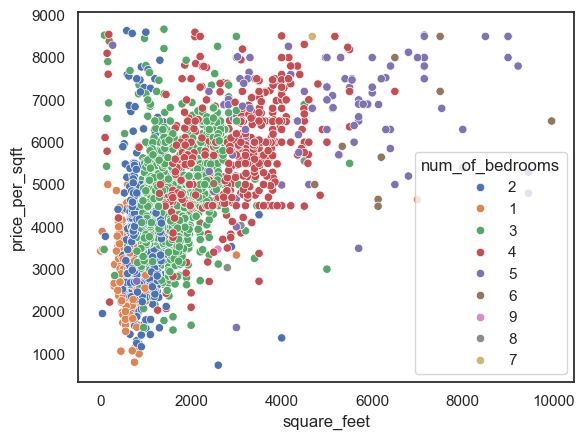

In [29]:
### Understanding relationship between flat area as square_feet vs price_per_sqft wrt number_of_bedrooms

sns.scatterplot(data=df, x="square_feet", y="price_per_sqft", hue="num_of_bedrooms")

In [30]:
df.groupby(['num_of_bedrooms'])['price_per_sqft'].mean()

num_of_bedrooms
1    2986.481132
2    3815.136108
3    4714.608362
4    5715.386609
5    6634.149533
6    6328.777778
7    8500.000000
8    4208.000000
9    3472.000000
Name: price_per_sqft, dtype: float64

#### Thats Conclusive. 7BHK is costliest and 2BHK is cheapest. 8BHK and 9BHK are cheaper to 7BHK as its Unfurnished.

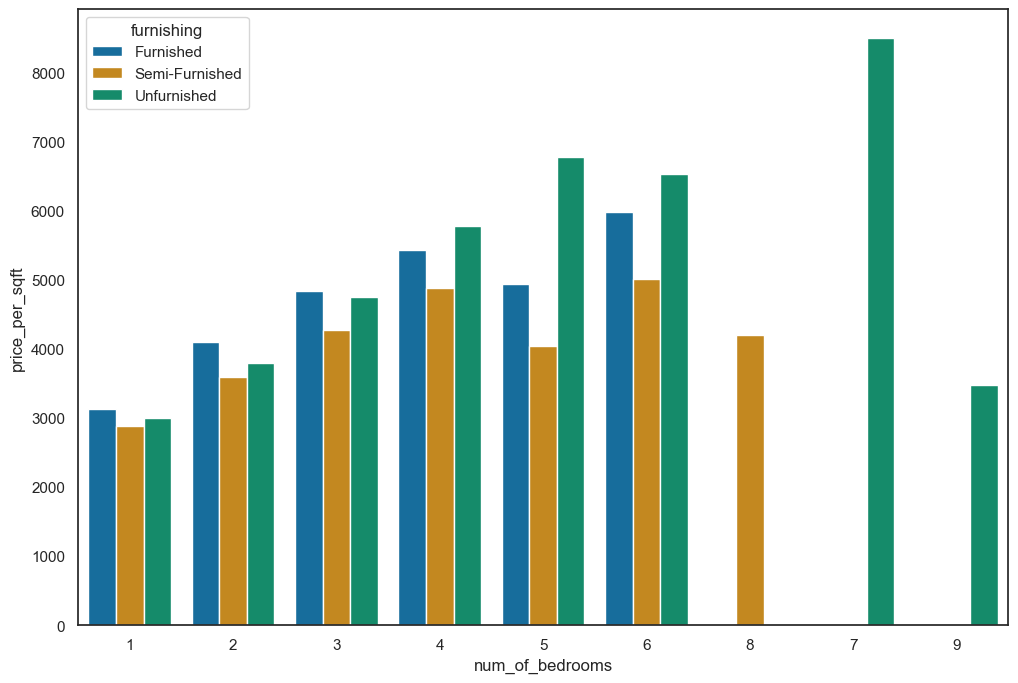

In [31]:
df_fur = df[df['furnishing'].isin(['Unfurnished', 'Semi-Furnished', 'Furnished'])]
df_fur_grp = df_fur.groupby(['furnishing', 'num_of_bedrooms'])['price_per_sqft'].mean()
df_fur_grp = df_fur_grp.reset_index()
plt.figure(figsize=(12, 8))  # Set the figure size
ax = sns.barplot(data=df_fur_grp, x='num_of_bedrooms', y='price_per_sqft', hue='furnishing', palette='colorblind')  # Create the bar plot

## Let's Check region in Surat with Higher Land Value

In [32]:
### Checking top 10 regions in Surat with high price per square feet of land
top_10_area = df.groupby(['area'])['price_per_sqft'].mean().sort_values(ascending=False).head(10)
top_10_area = top_10_area.reset_index()

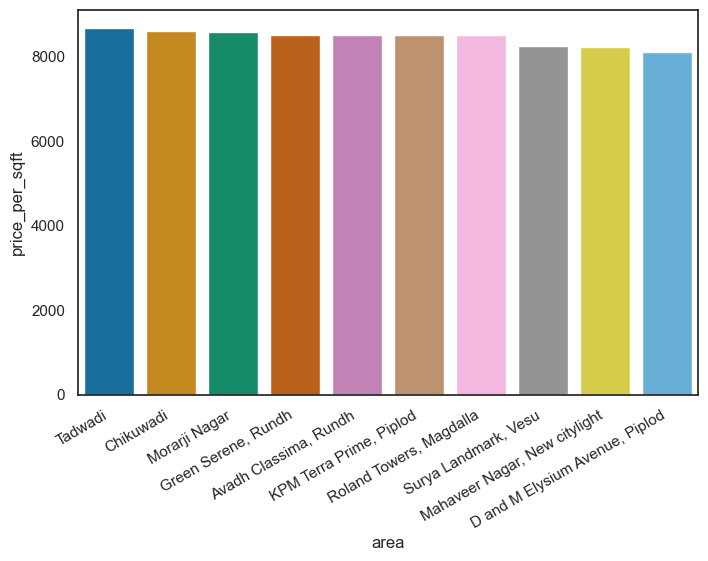

In [33]:
plt.figure(figsize=(8, 5))
ax = sns.barplot(data=top_10_area, x='area', y='price_per_sqft', palette='colorblind') 
plt.xticks(rotation=30, ha='right')
plt.show()

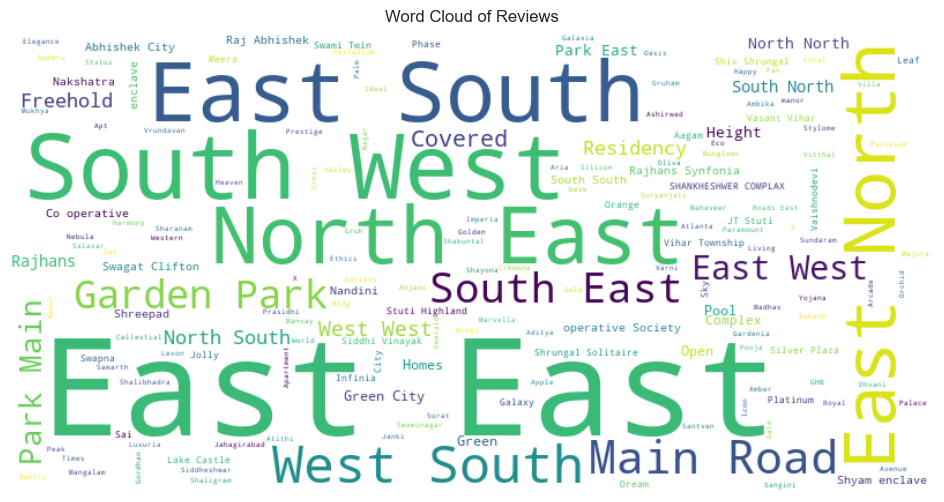

In [36]:
from wordcloud import WordCloud

reviews_text = ' '.join(df['facing'].dropna())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(reviews_text)
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud of Reviews')
plt.axis('off')
plt.show()

# Happy Coding !!!